In [1]:
import pandas as pd
from helpers import config
import plotly.express as px
from helpers.preprocessing import *
from helpers import config
%load_ext autoreload
%autoreload 2

In [8]:
def get_pair(df,m1,m2):
    return df[(df.market1==m1) * (df.market2==m2)]

def keep_positive(x):
    """return the data for which lags are positive ON AVERAGE"""
    to_keep = x[["lag","pair"]].groupby("pair").mean()>0#.set_index("pair")
    to_keep = to_keep.rename(columns={"lag":"lag+"})
    x = x.set_index("pair").join(to_keep,how="inner").reset_index()
    return x[x["lag+"]]

def remove_outliers(df,confidence=0.95):
    quantile = df["lag"].abs().quantile(q=confidence)
    return df[df.lag.abs() <= quantile]

def add_pair_names(df):
    df["pair"] = df["market1"]+"_"+df["market2"]
    return df

## Loading lag data

In [38]:
lags_ret = pd.read_csv(config["files"]["results"]["all_best_lags"].format("_".join(["numeric","log_returns"])))
lags_price = pd.read_csv(config["files"]["results"]["all_best_lags"].format("_".join(["numeric"])))

In [39]:
lags_ret = lags_ret.sort_values("date")

# Plotting lags

In [40]:
def plot_pair_lags(df,m1,m2):
    fig = px.line(get_pair(best_lags,m1,m2), x="date", y="lag", title=f"lags vs date between {m1}/{m2}")
    fig.show()

def plot_all_pairs(df,rolling_window=1):
    to_plot = df.copy()
    to_plot = add_pair_names(to_plot)
    to_plot = keep_positive(to_plot)
    to_plot = remove_outliers(to_plot,confidence = 0.99)
    
    # rolling average
    to_plot["lag"] = moving_average(to_plot.lag,w=rolling_window)
    
    fig = px.line(to_plot, x="date", y="lag",color="pair", title=f"lags vs date (all pairs)",log_y=False)
    fig.show()

In [41]:
plot_all_pairs(lags_price,10)

In [42]:
plot_all_pairs(lags_ret,10)

https://www.24heures.ch/economie/benefice-net-shell-divise-huit-2015/story/29746011
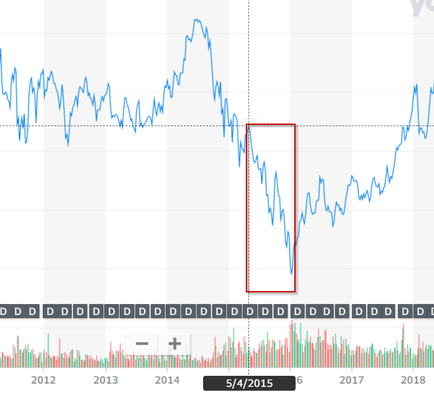

# Lags vs distance

In [29]:
def plot_lag_vs_distance(lags_data,date1,date2):
    mean_lags = []
    distances = []
    for m1 in config["markets"]["list"]:
        for m2 in config["markets"]["list"]:
            if m1>m2:
                locality_data = get_pair(lags_data,m1,m2)
                locality_data = locality_data[(locality_data["date"]>=date1)*(locality_data["date"]<=date2)]
                mean_lag      = locality_data.lag.abs().mean()
                distance = config["distances"][m1][m2]

                mean_lags.append(mean_lag)
                distances.append(distance)
    to_plot = pd.DataFrame({"distance": distances,"mean_lag":mean_lags})

    fig = px.scatter(to_plot, x=f"distance", y="mean_lag",trendline="ols") 
    fig.update_layout(
    title=f"mean lag vs distance ({date1} to {date2})",
    xaxis_title="distance(km)",
    yaxis_title="mean lag(ms)")  
    fig.show()

In [30]:
date1,date2 = "2010-00-00","2012-12-31"

plot_lag_vs_distance(lags_price,date1,date2)

# Lag vs Liquidity

In [33]:
# loading liquidity data
liquidity_data = pd.read_csv(config["files"]["results"]["liquidity"])

In [34]:
def combine_lag_and_liquididty(lags_data,liquidity_data):
    x = liquidity_data.merge(lags,left_on=["date","market"],right_on=["date","market1"])\
                        .rename(columns={"period":"period1"}).drop(columns=["market"])
    x = liquidity_data.merge(x,left_on=["date","market"],right_on=["date","market2"])\
                            .rename(columns={"period":"period2"}).drop(columns=["market"])
    x["perdiod_diff"] = (x.period1 - x.period2).abs()
    return x

## Visualization

In [35]:
def plot_lag_vs_perdiod(lags_data,liquidity_data,period="perdiod_diff",distinguish_markets=True):
    # combine the dataframes
    to_plot = combine_lag_and_liquididty(lags_data,liquidity_data)
    
    to_plot = add_pair_names(to_plot)
    to_plot = keep_positive(to_plot)
    to_plot["lag"] = to_plot["lag"].abs()
    to_plot = remove_outliers(to_plot)
    
    discriminator = None
    if distinguish_markets:
        discriminator = "pair"
    fig = px.scatter(to_plot, x=f"perdiod_diff", y="lag", color=discriminator,trendline="ols")  
    fig.update_layout(
    title=f"daily lag vs {period}",
    xaxis_title=f"{period}(s)",
    yaxis_title="lag(ms)")  
    fig.show()

In [36]:
plot_lag_vs_perdiod(lags_price,liquidity_data,period="perdiod_diff",distinguish_markets=False)

In [37]:
plot_lag_vs_perdiod(lags_price,liquidity_data,period="perdiod_diff",distinguish_markets=True)

## OLS

In [143]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


def ols_analysis(lags_data,liquidity_data,period = "perdiod_diff",distinguish_markets=False):
    # prepare data
    ols_data = combine_lag_and_liquididty(lags_data,liquidity_data)
    ols_data = add_pair_names(ols_data)
    ols_data = keep_positive(ols_data)
    ols_data["lag"] = ols_data["lag"].abs()
    ols_data = remove_outliers(ols_data)
    
    # prepare ols epression
    
    ols_expr = f"lag ~ {period}"
    if distinguish_markets:
        ols_expr+=" + C(pair)"
    
    # fit ols
    results = smf.ols(ols_expr, data=ols_data).fit()
    
    print(results.summary())

In [144]:
ols_analysis(lags_price,liquidity_data,period = "perdiod_diff",distinguish_markets=True)
   

                            OLS Regression Results                            
Dep. Variable:                    lag   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     88.87
Date:                Mon, 24 Jan 2022   Prob (F-statistic):           1.72e-52
Time:                        18:03:31   Log-Likelihood:                -14261.
No. Observations:                1356   AIC:                         2.853e+04
Df Residuals:                    1352   BIC:                         2.855e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         8000.6970    574.281  